# MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

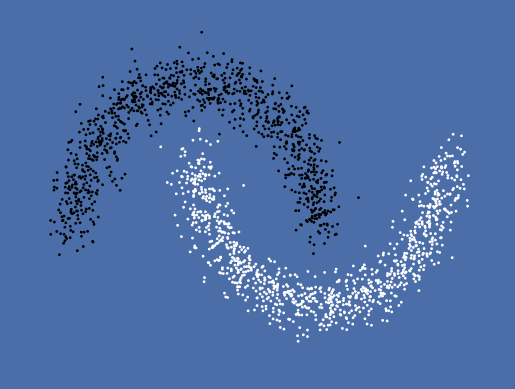

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [2]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
  
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [3]:
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        self.output = np.maximum(0, x)
        return self.output
        raise NotImplementedError()
        
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        index = self.output > 0
        num_index = np.array((index), dtype=np.float32)
        return grad_output * num_index
        raise NotImplementedError()
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        raise NotImplementedError()

class MySigmoid(object):
    def forward(self, x):
        self.X=x # hold a copy of input
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        self.output=1./(1. + np.exp(-self.X))
        return self.output
        raise NotImplementedError()
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        gradient = np.exp(-self.X) / (1.+ np.exp(-self.X))**2
        return grad_output * gradient
        raise NotImplementedError()
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        raise NotImplementedError()

Probably a good time to test your functions...

In [4]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])

array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [5]:
test_relu.backward(np.ones(1))

array([0., 0., 1., 0., 1., 1.])

In [6]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [7]:
test_sig.backward(np.ones(1))

array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [8]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        self.W = np.random.randn(n_input, n_output)
        self.b = np.random.randn(1, n_output)
        # raise NotImplementedError()

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        # return Wx + b
        self.X = np.array(x)
        return (self.X @ self.W + self.b)
        raise NotImplementedError()

    def backward(self, grad_output):
        # y_i = \sum_j W_{i,j} x_j + b_i
        # d y_i / d W_{i, j} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        self.dL_dW = self.X.T @ grad_output
        # raise NotImplementedError()
        
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        self.dL_db = grad_output
        # raise NotImplementedError()
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        self.dL_dx = grad_output  @ (self.W).T 
        return self.dL_dx
        raise NotImplementedError()
    
    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        self.W -= learning_rate * self.dL_dW
        self.b -= learning_rate * self.dL_db
        # raise NotImplementedError()

Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [9]:
class Sequential(object):
    def __init__(self, n_mid_layers):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        self.linear1 = MyLinear(2, n_mid_layers)
        self.relu = MyReLU()
        self.linear2 = MyLinear(n_mid_layers, 1)
        self.sigmoid = MySigmoid()
        # raise NotImplementedError()
        
    def forward(self, x):
        self.output1 = self.linear1.forward(x)
        self.output2 = self.relu.forward(self.output1)
        self.output3 = self.linear2.forward(self.output2)
        self.output4 = self.sigmoid.forward(self.output3)
        return self.output4
        raise NotImplementedError()
    
    def compute_loss(self, out, label):
        # use the BCE loss
        # -(label * log(output) + (1-label) * log(1-output))
        # save the gradient, and return the loss      
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        loss = -(label * np.log(out+ 1e-10) + (1-label) * np.log(1-out+1e-10))
        self.lossgradient = -(label/(out+1e-10)-(1-label)/(1-out+1e-10))
        return loss
        raise NotImplementedError()

    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        gradient1=self.sigmoid.backward(self.lossgradient)
        gradient2=self.linear2.backward(gradient1)
        gradient3=self.relu.backward(gradient2)
        self.linear1.backward(gradient3)
        # raise NotImplementedError()
    
    def step(self, learning_rate):
        # take a gradient step for each layers
        self.linear1.step(learning_rate)
        self.linear2.step(learning_rate)
        # raise NotImplementedError()

In [12]:
# define your network with your Sequential Class
net = Sequential(n_mid_layers=64)

In [13]:
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    for it in range(len(X)):
        j = np.random.randint(1, len(X))
        # select the corresponding example and label
        example = X[j:j+1]
        label = Y[j]
        
        # do a forward pass on the example
        output=net.forward(example)
        # raise NotImplementedError()
        # compute the loss according to your output and the label
        loss=net.compute_loss(output,label)
        losses.append(loss[0])
        # raise NotImplementedError()
        
        # backward pass
        net.backward()
        # raise NotImplementedError()
        
        # gradient step
        net.step(learning_rate)

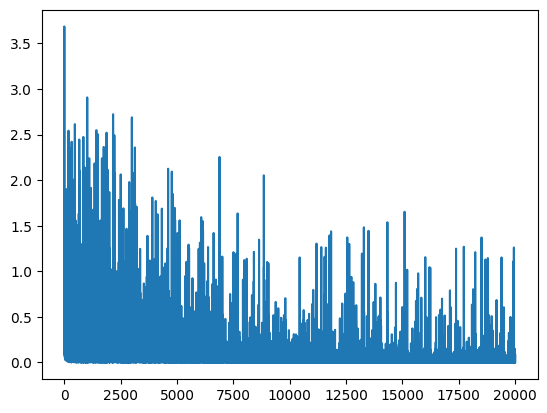

In [14]:
%matplotlib inline
plt.plot(losses)
plt.show()

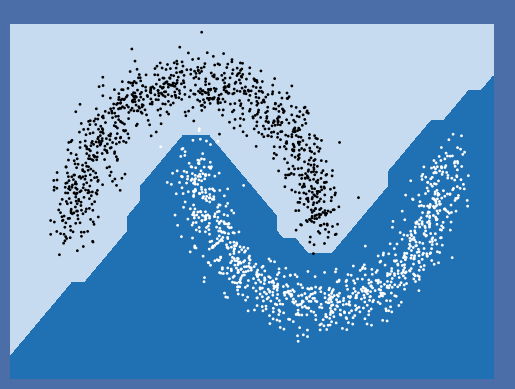

In [15]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, net)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

In [16]:
import torch
import torch.nn as nn

# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        self.A = nn.Parameter(torch.normal(0, 1, size=(n_input, n_output)))
        self.b = nn.Parameter(torch.normal(0, 1, size=(1, n_output)))
        # raise NotImplementedError()

    def forward(self, x):
        output=x@self.A+self.b
        return output
        raise NotImplementedError()
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        self.relu=nn.ReLU()
    def forward(self, x):
        output=self.relu(x)
        return output
        raise NotImplementedError()

In [18]:
to_forward = torch.from_numpy(np.array(list(zip(xx.ravel(), yy.ravel())))).float()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

In [21]:
df = pd.read_csv('imdb_dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## 3.2. MLP in torch

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [22]:
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader
# Note that you should transform your X, y to torch.Tensor

In [23]:
h=64
num_of_data = 20000

net=nn.Sequential(
    MyLinear_mod(5000,h),
    MyReLU_mod(),
    MyLinear_mod(h,h),
    MyReLU_mod(),
    MyLinear_mod(h,1),
    nn.Sigmoid()
)

In [24]:
from torch import optim

optimizer = optim.SGD(net.parameters(), lr=1e-2)

corpus = df.iloc[:num_of_data]['review']
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(corpus)

encoder = LabelEncoder()
y = encoder.fit_transform(df.iloc[:num_of_data]['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X.A, y, test_size=0.2, random_state=42)

losses = []

X_torch = torch.from_numpy(X_train).float()
print(X_torch.shape, X_train.shape)
y_torch = torch.from_numpy(y_train).float()
np.random.seed(0)

criterion = nn.BCELoss()
cnt_all = 0
correct = 0
for i in range(10):
  print(f"EPOCH {i+1}")
  for it in range(int(num_of_data/2)):
      # pick a random example id 
      j = np.random.randint(1, len(X_torch))

      # select the corresponding example and label
      example = X_torch[j:j+1]
      label = y_torch[j:j+1].unsqueeze(1)
      # print(example.shape)
      # print(example)
      
      # do a forward pass on the example
      output=net(example)

      # raise NotImplementedError()

      # compute the loss according to your output and the label
      loss=criterion(output,label)
      losses.append(loss.item())
      # raise NotImplementedError()

      # zero the gradients
      optimizer.zero_grad()
      # raise NotImplementedError()

      # backward pass
      loss.backward()
      # raise NotImplementedError()

      # gradient step
      optimizer.step()

torch.Size([16000, 5000]) (16000, 5000)
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10


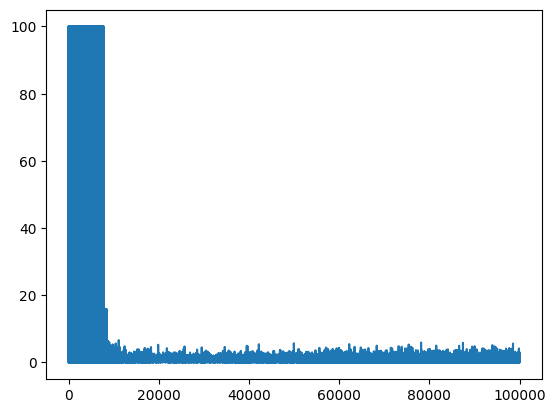

In [25]:
plt.plot(losses)

In [26]:
all = 0
cnt = 0
X_torch_test = torch.from_numpy(X_test).float()
y_torch_test = torch.from_numpy(y_test).float()
for i, example in enumerate(X_torch_test):
    output = net(example)
    all += 1
    if torch.round(output) == y_torch_test[i:i+1].unsqueeze(1):
        cnt += 1

print(cnt/all * 100)

70.72500000000001
